<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Модель-для-0-региона" data-toc-modified-id="Модель-для-0-региона-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Модель для 0 региона</a></span><ul class="toc-item"><li><span><a href="#Модель-для-1-региона" data-toc-modified-id="Модель-для-1-региона-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Модель для 1 региона</a></span></li><li><span><a href="#Модель-для-2-региона" data-toc-modified-id="Модель-для-2-региона-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Модель для 2 региона</a></span></li></ul></li><li><span><a href="#Расчет-прибыли" data-toc-modified-id="Расчет-прибыли-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Расчет прибыли</a></span><ul class="toc-item"><li><span><a href="#Расчет-рисков-и-прибыли-для-каждого-региона" data-toc-modified-id="Расчет-рисков-и-прибыли-для-каждого-региона-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Расчет рисков и прибыли для каждого региона</a></span></li></ul></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

# Выбор локации для скважины

Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Надо построить модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой Bootstrap. Предоставлены данные о регионах:

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

Условия задачи:
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.


***Цель исследования***:
1. Проанализировать полученные данные
2. Обучить модели для каждого региона
3. Написать функцию для расчета прибыли
4. Посчитать риски и прибыль для каждого региона

***Ход исследования***:
1. Получим данные из исходных датасетов
2. Предобработаем данные: поищем пропуски, дубликаты.
3. Проведем исследовательский анализ данных всех полученных датасетов
4. Посмотрим на корреляцию между признаками
5. Обучим модели для регионов
6. Рассчитаем прибыль
7. Сделаем общий вывод по работе, дадим рекомендации по выбору региона для скважин


In [1]:
!pip install -q scikit-learn==1.5.0 -q
!pip install --upgrade shap matplotlib seaborn -q

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  
import phik
from phik.report import plot_correlation_matrix
from phik import phik_matrix
import shap
from IPython.display import Markdown, display
sns.set_theme(style="whitegrid")
RANDOM_STATE = 42

### Загрузка данных

In [3]:
try:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv', sep=",")
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv', sep=",")
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv', sep=",")
    print('Код выполняется на платформе')
except FileNotFoundError:
    geo_data_0 = pd.read_csv('datasets/geo_data_0.csv', sep=",")
    geo_data_1 = pd.read_csv('datasets/geo_data_1.csv', sep=",")
    geo_data_2 = pd.read_csv('datasets/geo_data_2.csv', sep=",")
    print('Код выполняется локально')

Код выполняется локально


In [4]:
geo_data_list = [geo_data_0, geo_data_1, geo_data_2]

In [5]:
for i, geo_data in enumerate(geo_data_list):
    display(Markdown(f'<center><b>geo_data_{i} info</b></center>'), geo_data.head(5))
    geo_data.info()

<center><b>geo_data_0 info</b></center>

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


<center><b>geo_data_1 info</b></center>

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


<center><b>geo_data_2 info</b></center>

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В полученных датасетах все выглядит хорошо: все значения заполнены, типы данных в числовых переменных везде float.

### Предобработка данных

In [6]:
for geo_data in geo_data_list:
    print(geo_data[geo_data.isna().any(axis=1)].shape)

(0, 5)
(0, 5)
(0, 5)


In [7]:
for geo_data in geo_data_list:
    print(geo_data[geo_data.duplicated()].shape)

(0, 5)
(0, 5)
(0, 5)


In [8]:
for geo_data in geo_data_list:
    print(geo_data[geo_data['id'].duplicated()].shape)

(10, 5)
(4, 5)
(4, 5)


Полных дубликатов и пропусков нет, но есть немного повторяющихся id. Ничего с ними делать не будем, так как их очень мало.

### Исследовательский анализ данных

In [9]:
def figures_for_num(data, numeric_col):
    if len(numeric_col) != 1:
        fig, axes = plt.subplots(len(numeric_col), 2, figsize=(10,len(numeric_col)*5))
        i = 0
        plt.subplots_adjust(hspace=0.3)
        for column in numeric_col:
            axes[i,0].set_title(f'KDE для параметра \n {column}')
            axes[i,1].set_title(f'Boxplot для параметра \n {column}')
            sns.kdeplot(ax = axes[i,0], data=data, x=column)
            sns.boxplot(ax = axes[i,1], data=data, x=column)
            i += 1
    else:
        column = numeric_col[0]
        fig, axes = plt.subplots(1, 2, figsize=(10,4))
        plt.subplots_adjust(hspace=0.3)
        axes[0].set_title(f'KDE для параметра \n {column}')
        axes[1].set_title(f'Boxplot для параметра \n {column}')
        sns.kdeplot(ax = axes[0], data=data, x=column)
        sns.boxplot(ax = axes[1], data=data, x=column)

In [10]:
def figures_for_category(data, category_col):
    if len(category_col) != 1:
        fig, axes = plt.subplots(len(category_col), figsize=(7,len(category_col)*5))
        plt.subplots_adjust(hspace=0.3)
        i = 0
        for column in category_col:
            axes[i].set_title(f'Гистограмма для параметра \n {category_col[i]}')
            ax = sns.countplot(ax = axes[i], data=data, x=column,
                               order=data[column].value_counts(ascending=False).index)
            abs_values = data[column].value_counts(ascending=False).values
            ax.bar_label(container=ax.containers[0], labels=abs_values)
            i += 1
    else:
        column = category_col[0]
        ax = sns.countplot(data=data, x=column,
                           order=data[column].value_counts(ascending=False).index)
        abs_values = data[column].value_counts(ascending=False).values
        ax.bar_label(container=ax.containers[0], labels=abs_values)  
        ax.set_title(f'Гистограмма для параметра \n {column}')

In [11]:
for i, geo_data in enumerate(geo_data_list):
    display(Markdown(f'<center><b>geo_data_{i} description</b><center>'), geo_data.describe().T)

<center><b>geo_data_0 description</b><center>

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


<center><b>geo_data_1 description</b><center>

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


<center><b>geo_data_2 description</b><center>

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


In [12]:
numeric_columns = geo_data_0.select_dtypes('number').columns.to_list()
numeric_columns

['f0', 'f1', 'f2', 'product']

<center><b>geo_data_0 graphics</b><center>

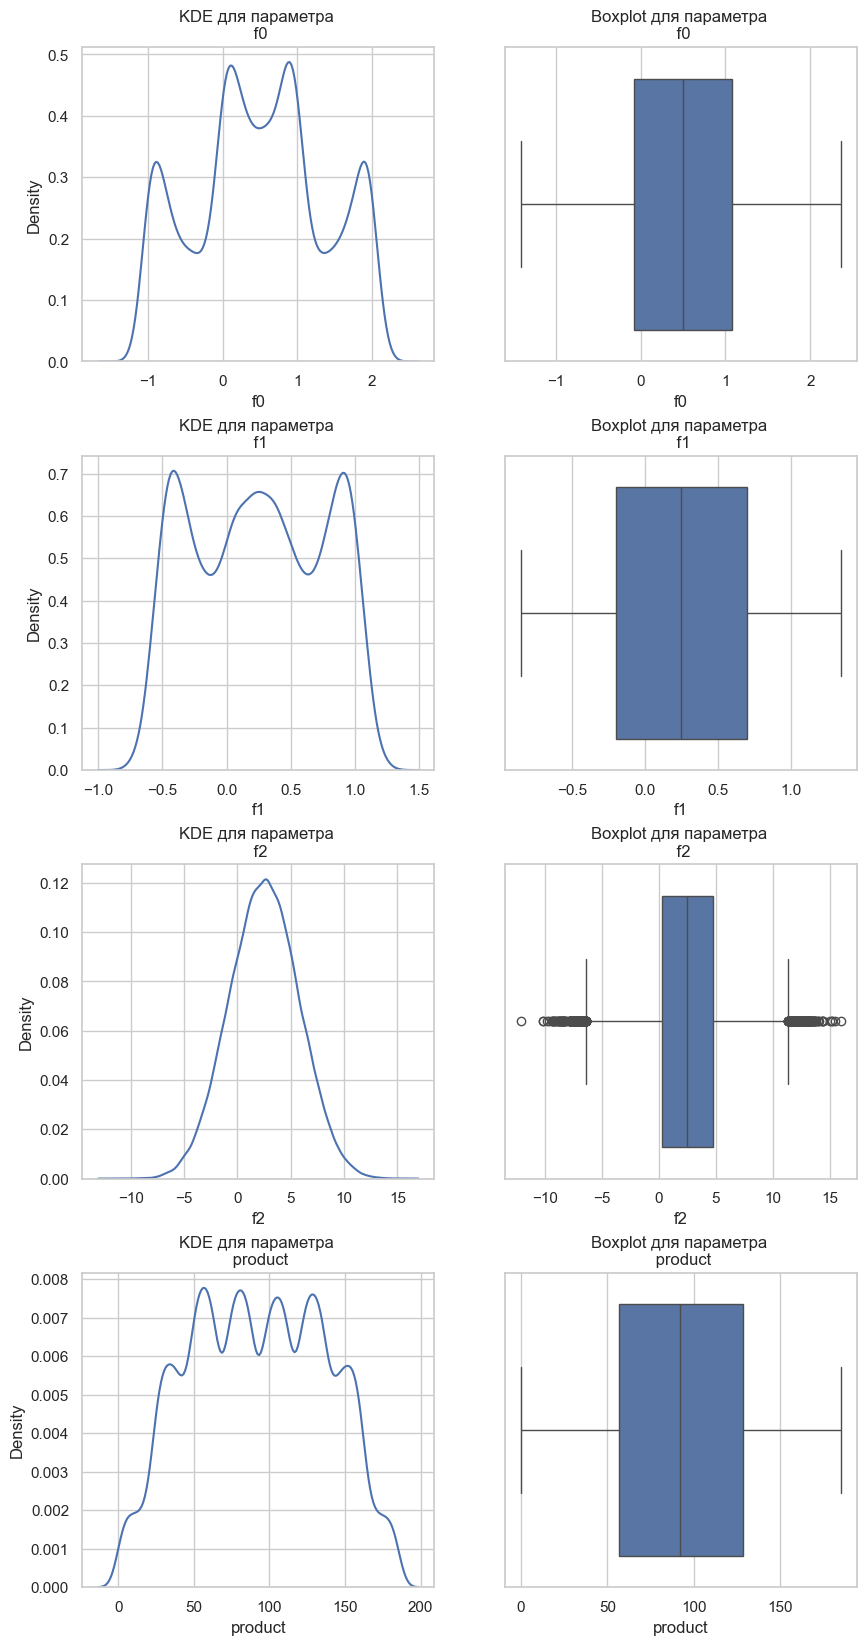

In [13]:
display(Markdown(f'<center><b>geo_data_0 graphics</b><center>'))
figures_for_num(geo_data_0, numeric_columns)

<center><b>geo_data_1 graphics</b><center>

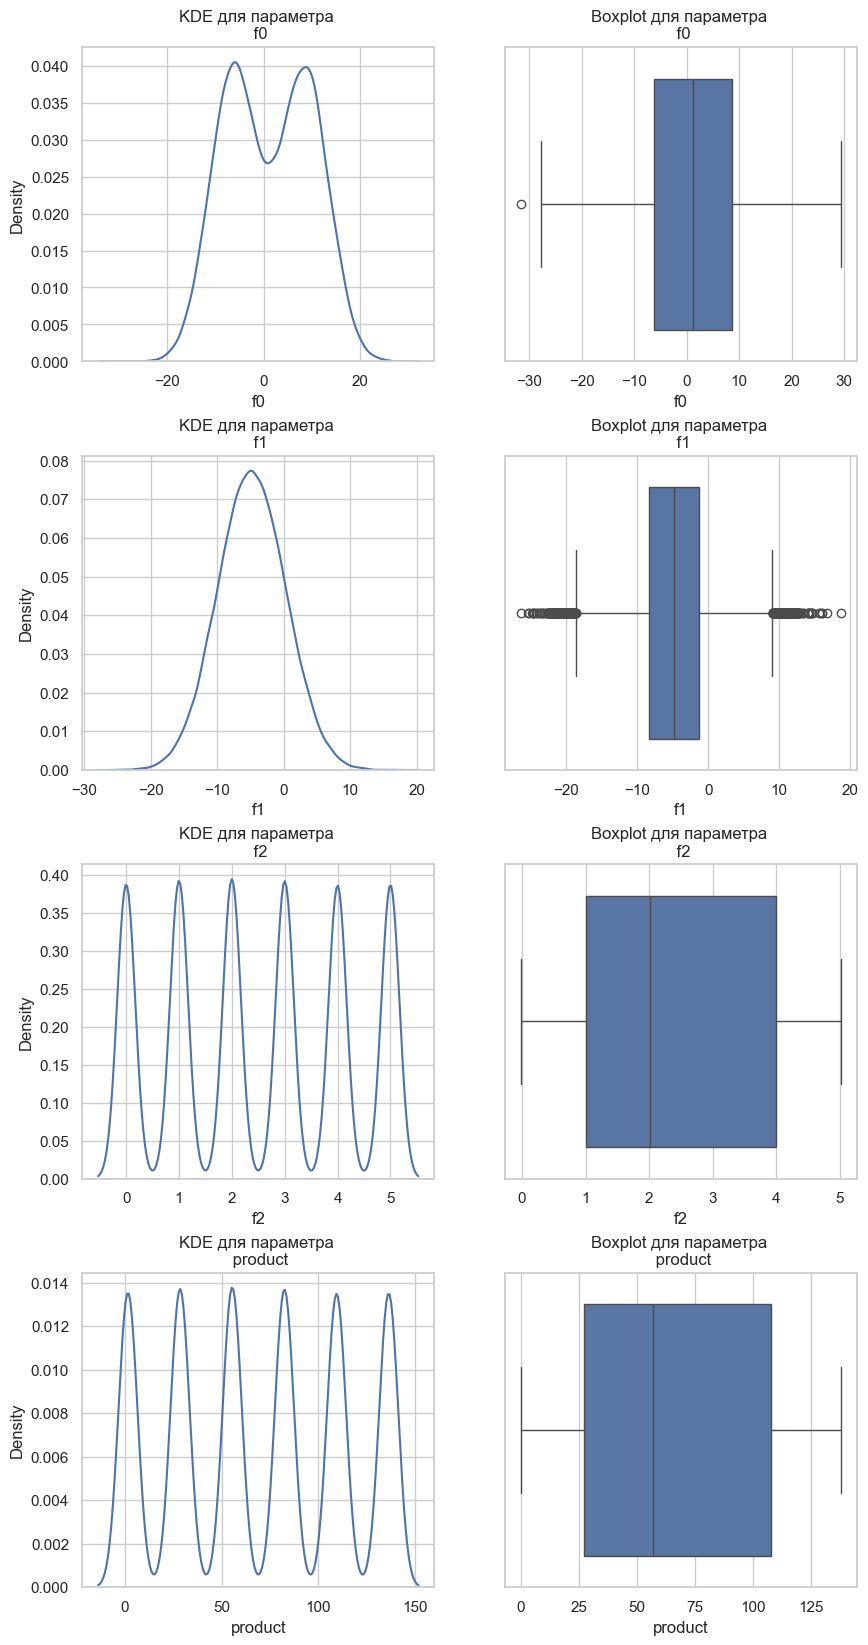

In [14]:
display(Markdown(f'<center><b>geo_data_1 graphics</b><center>'))
figures_for_num(geo_data_1, numeric_columns)

<center><b>geo_data_2 graphics</b><center>

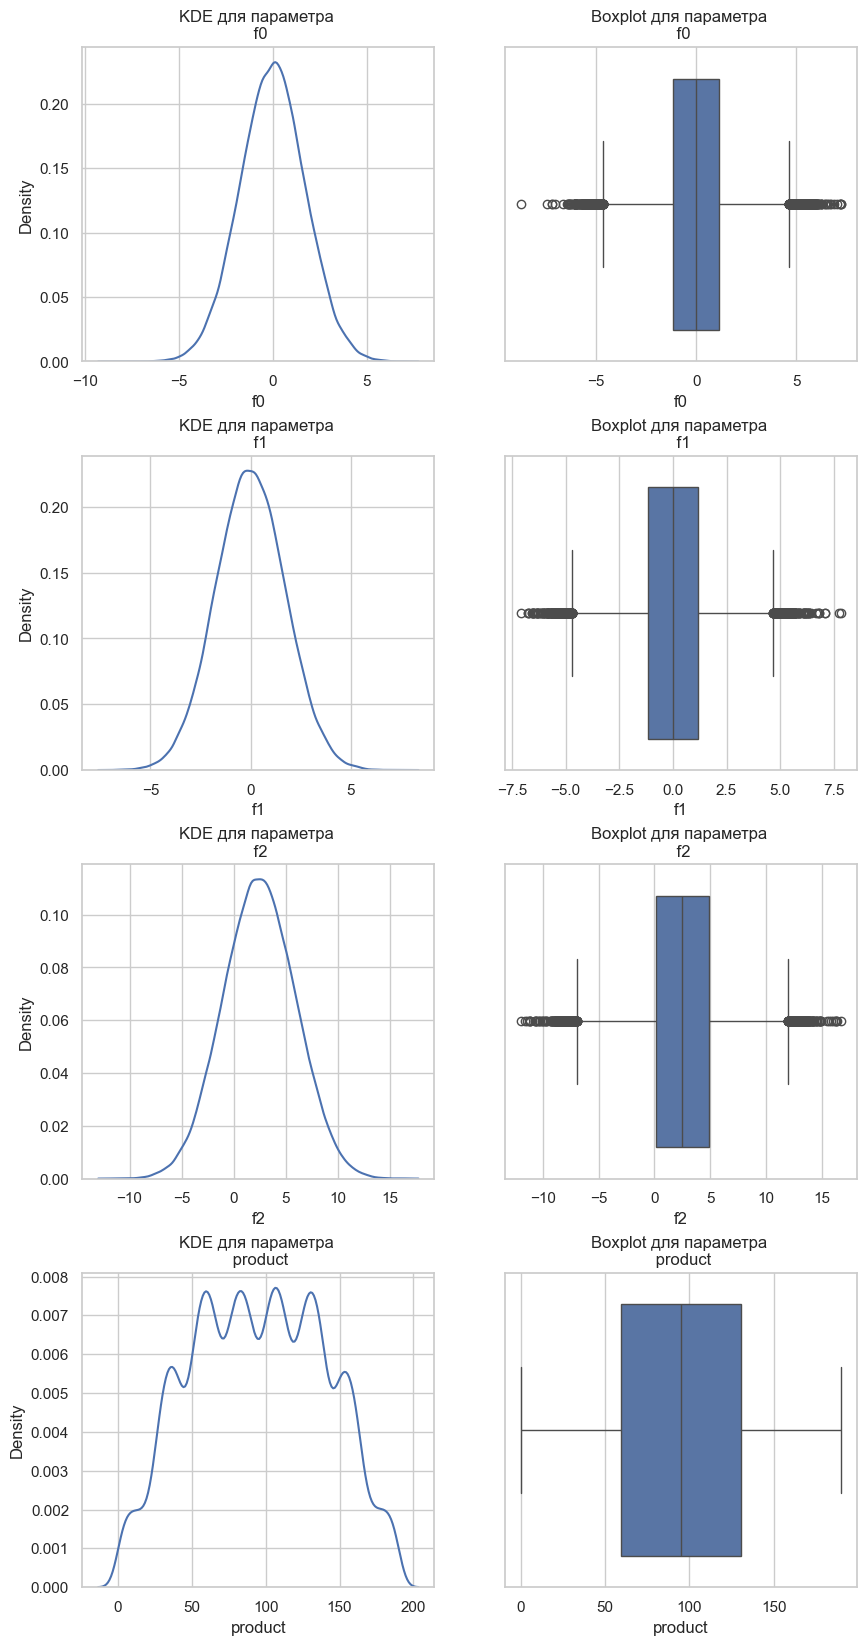

In [15]:
display(Markdown(f'<center><b>geo_data_2 graphics</b><center>'))
figures_for_num(geo_data_2, numeric_columns)

На построеных графиках для 0 и 2 региона не видно никаких закономерностей, а вот на графиках для региона 1 можем видеть похожие закономерности у product и f1. Проанализируем это матрицами корреляции и рассеяния.

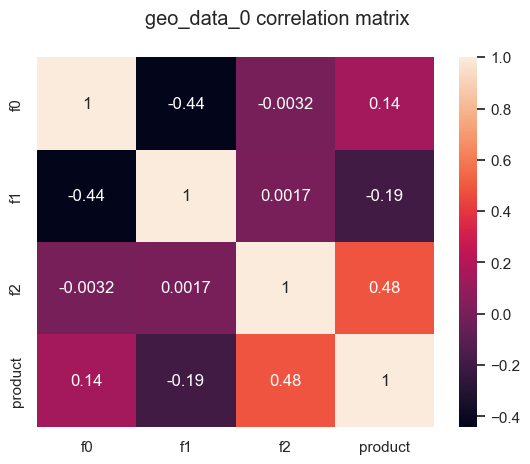

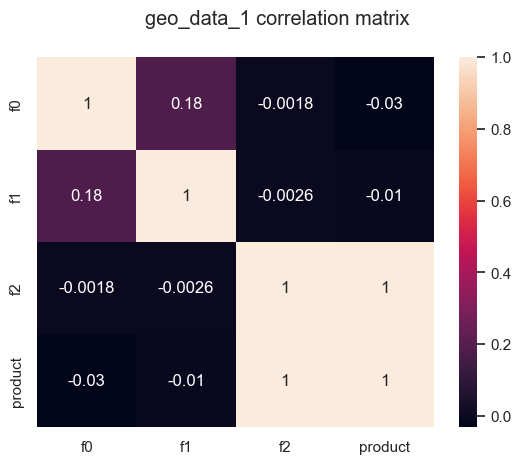

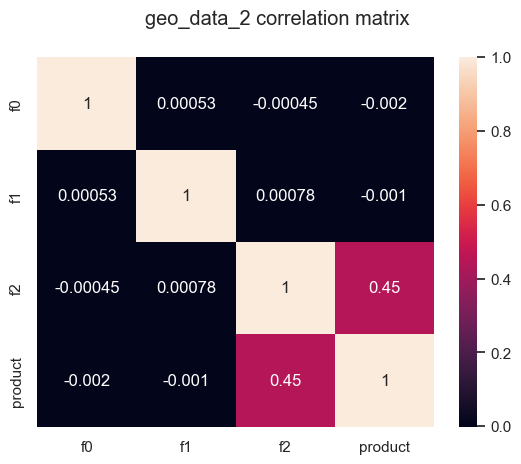

In [16]:
for i, geo_data in enumerate(geo_data_list):
    data = geo_data[['f0', 'f1', 'f2', 'product']]
    sns.heatmap(data.corr(), annot=True)
    plt.suptitle(f"geo_data_{i} correlation matrix")
    plt.show()

<center><b>geo_data scatter plots graphics</b></center>

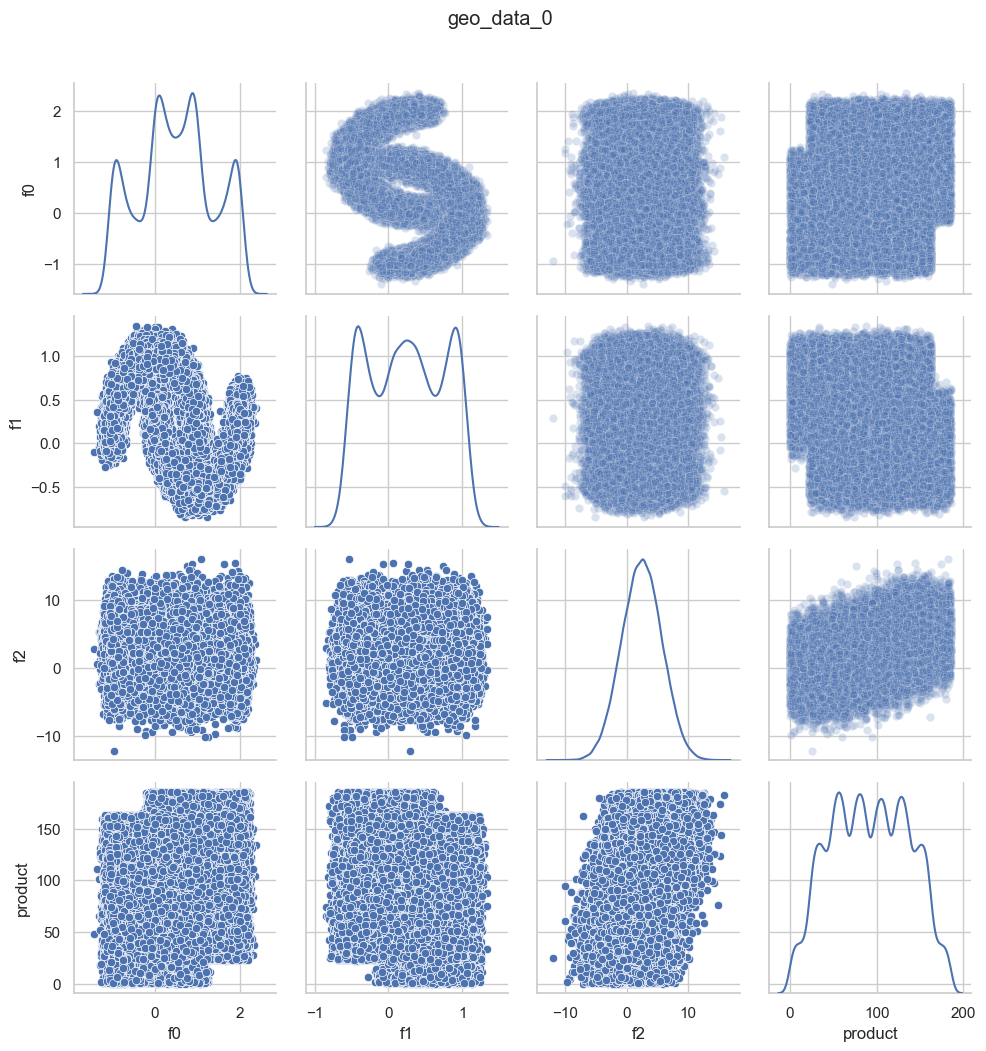

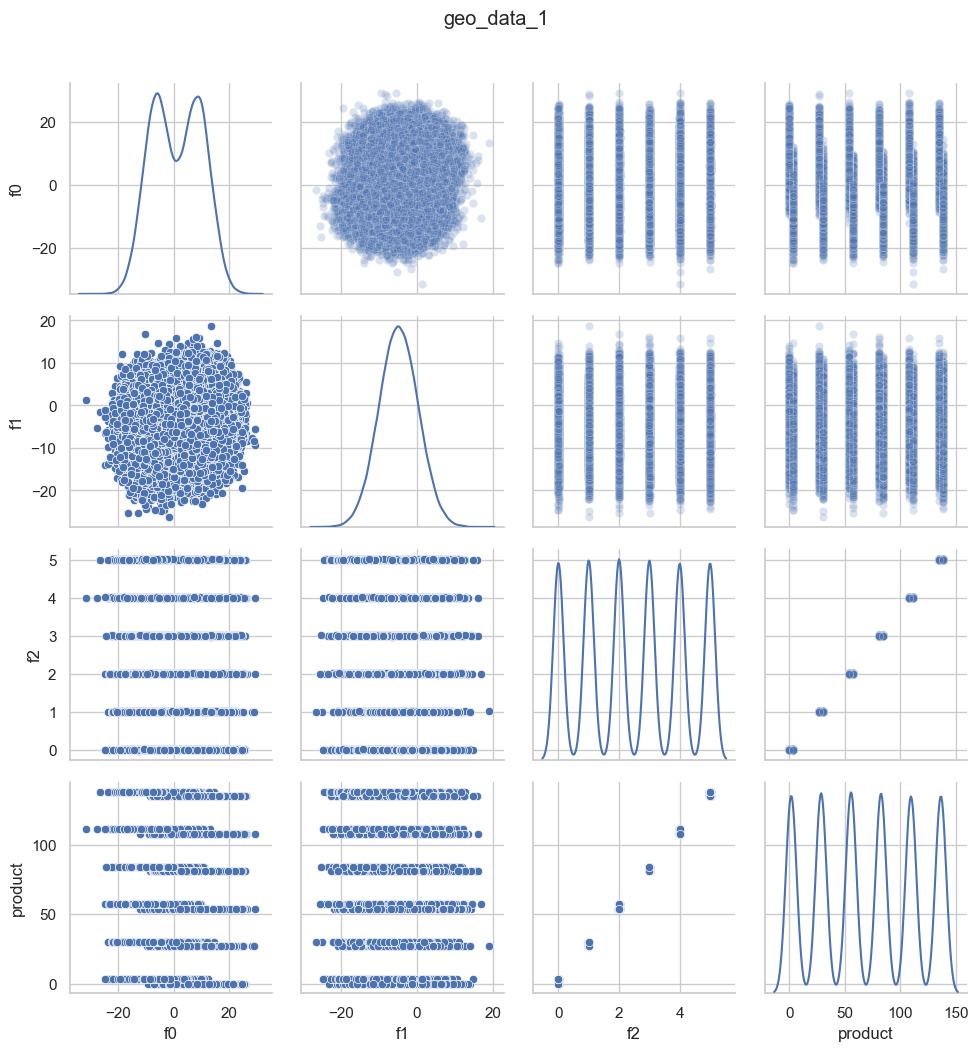

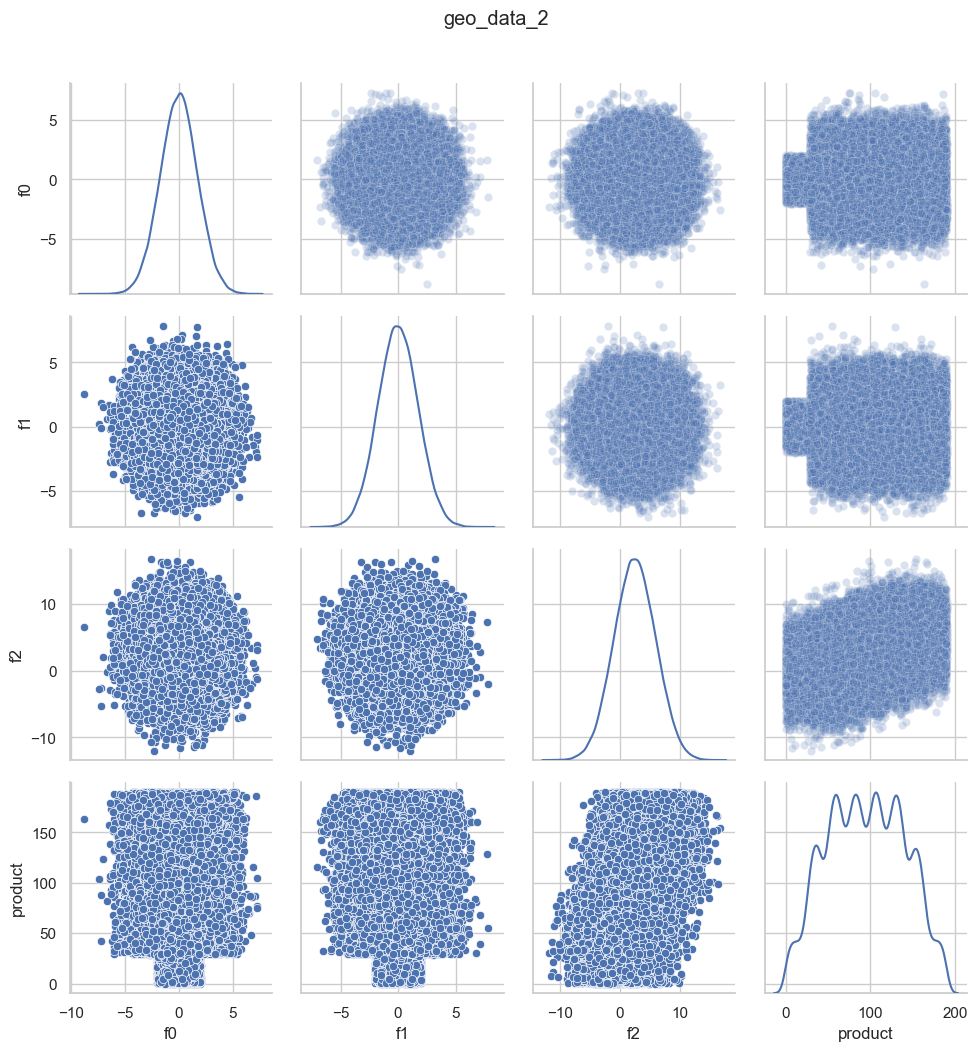

In [17]:
display(Markdown(f'<center><b>geo_data scatter plots graphics</b></center>'))
for i, geo_data in enumerate(geo_data_list):
    data = geo_data[['f0', 'f1', 'f2', 'product']]
    g = sns.PairGrid(data, diag_sharey=False)
    g.map_upper(sns.scatterplot, alpha=0.2)
    g.map_lower(sns.scatterplot)
    g.map_diag(sns.kdeplot)
    g.fig.suptitle(f"geo_data_{i}", y=1.05)
    plt.show()

По полученным матрицам корреляции и графикам рассеяния признаков, явно видим сильную корреляцию во втором датасете между признаком f2 и product. В остальных случаев сильная корреляция не обнаружена.

### Обучение моделей

### Модель для 0 региона

In [18]:
X_0 = geo_data_0.drop(columns = ['id','product'])
y_0 = geo_data_0['product']
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=0.25,
                                                            random_state=RANDOM_STATE)

In [19]:
model_0 = LinearRegression()

In [20]:
model_0.fit(X_train_0, y_train_0)

LinearRegression()

In [21]:
y_pred_0 = model_0.predict(X_test_0)

In [22]:
rmse_0 = root_mean_squared_error(y_test_0, y_pred_0)
print(f"rmse: {rmse_0}")
print(f"mean: {y_pred_0.mean()}")

rmse: 37.75660035026169
mean: 92.39879990657768


In [23]:
geo_data_0['pred_product'] = model_0.predict(geo_data_0[['f0','f1','f2']])
geo_data_0.head(3)

,id,f0,f1,f2,product,pred_product
0,txEyH,0.705745,-0.497823,1.221170,105.280062,95.521901
1,2acmU,1.334711,-0.340164,4.365080,73.037750,116.413581
2,409Wp,1.022732,0.151990,1.419926,85.265647,88.780551


#### Модель для 1 региона

In [24]:
X_1 = geo_data_1.drop(columns = ['id','product'])
y_1 = geo_data_1['product']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.25,
                                                            random_state=RANDOM_STATE)

In [25]:
model_1 = LinearRegression()

In [26]:
model_1.fit(X_train_1, y_train_1)

LinearRegression()

In [27]:
y_pred_1 = model_1.predict(X_test_1)

In [28]:
rmse_1 = root_mean_squared_error(y_test_1, y_pred_1)
print(f"rmse: {rmse_1}")
print(f"mean: {y_pred_1.mean()}")

rmse: 0.8902801001028854
mean: 68.71287803913762


In [29]:
geo_data_1['pred_product'] = model_1.predict(geo_data_1[['f0','f1','f2']])
geo_data_1.head(3)

,id,f0,f1,f2,product,pred_product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,3.842537
1,62mP7,14.272088,-3.475083,0.999183,26.953261,26.585852
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,135.665780


#### Модель для 2 региона

In [30]:
X_2 = geo_data_2.drop(columns = ['id','product'])
y_2 = geo_data_2['product']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.25,
                                                            random_state=RANDOM_STATE)

In [31]:
model_2 = LinearRegression()

In [32]:
model_2.fit(X_train_2, y_train_2)

LinearRegression()

In [33]:
y_pred_2 = model_2.predict(X_test_2)

In [34]:
rmse_2 = root_mean_squared_error(y_test_2, y_pred_2)
print(f"rmse: {rmse_2}")
print(f"mean: {y_pred_2.mean()}")

rmse: 40.14587231134218
mean: 94.77102387765939


In [35]:
geo_data_2['pred_product'] = model_2.predict(geo_data_2[['f0','f1','f2']])
geo_data_2.head(3)

,id,f0,f1,f2,product,pred_product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673,75.872848
1,WJtFt,0.262778,0.269839,-2.530187,56.069697,65.982700
2,ovLUW,0.194587,0.289035,-5.586433,62.871910,48.414360


Обучили модели для 3 регионов. Как и предполагалось, в связи с отсутствием сильных зависимостей в 0 и 2 регионов, среднеквадратичное отклонение в них довольно большое. Для 1 региона модель построила довольно точную модель, кторая дает небольшие отклонения.

### Расчет прибыли

In [36]:
product_income = 4.5e+05 #доход с одиницы продукта
budjet = 1.0e+10 #бюджет на разработку
n_points = 500 #количество исследуемых точек
n_best_points = 200 #количество отбираемых точек
max_loss_probability = 0.025 # максимальная допускаемая вероятность убытков
budjet_point = budjet / n_best_points # бюджет на одну скважину
print(f"бюджет на одну скважину {budjet_point:.2e}")
min_product = budjet_point / product_income
print(f"минимум сырья в точке для безубыточной разработки новой скважины {min_product:.2f}")

бюджет на одну скважину 5.00e+07
минимум сырья в точке для безубыточной разработки новой скважины 111.11


In [37]:
for i, geo_data in enumerate(geo_data_list):
    print(f"в регионе {i} среднее значение сырья {geo_data['product'].mean():.2f}")

в регионе 0 среднее значение сырья 92.50
в регионе 1 среднее значение сырья 68.83
в регионе 2 среднее значение сырья 95.00


In [38]:
def count_profit(data, n_best_points=200, budjet=1.0e+10, product_income=450000):
    data_points = data.sort_values(by='pred_product', ascending=False)['product']
    data_points.sort_values().reset_index(drop=True)
    profit = product_income * data_points[:n_best_points].sum() - budjet
    return profit

In [39]:
for i, geo_data in enumerate(geo_data_list):
    print(f"в регионе {i} значение прибыли в 200 лучших точках {count_profit(geo_data):.1e}")

в регионе 0 значение прибыли в 200 лучших точках 3.5e+09
в регионе 1 значение прибыли в 200 лучших точках 2.4e+09
в регионе 2 значение прибыли в 200 лучших точках 2.6e+09


#### Расчет рисков и прибыли для каждого региона

In [40]:
def bootstrap(data, n_points=n_points, state=RANDOM_STATE, n_best_points=n_best_points, product_income=product_income):
    state = np.random.RandomState(RANDOM_STATE)
    profit_values = []
    for i in range(1000):
        subsample = data.sample(n_points, replace=True, random_state=state).sort_values(by='pred_product')
        profit_values.append(count_profit(subsample))
    profit_values = pd.Series(profit_values)
    interval = np.array([profit_values.quantile(0.025), profit_values.quantile(0.975)])
    mean_profit = profit_values.mean()
    loss_prob = profit_values[profit_values<0].count() / profit_values.count() * 100 # result in %
    return interval, mean_profit, loss_prob

In [41]:
result = pd.DataFrame(columns=['region', 'interval_low/1e6', 'interval_high/1e6', 'mean_profit/1e6', 'loss_prob_%'])
for i, geo_data in enumerate(geo_data_list):
    interval, mean_profit, loss_prob = bootstrap(geo_data)
    result.loc[i, ['region', 'mean_profit/1e6', 'loss_prob_%']] = [f"geo_data_{i}", (mean_profit / 1e6), loss_prob]
    result.loc[i, ['interval_low/1e6', 'interval_high/1e6']] = interval/1e6
result

,region,interval_low/1e6,interval_high/1e6,mean_profit/1e6,loss_prob_%
0,geo_data_0,-43.085117,930.457387,430.333668,4.0
1,geo_data_1,94.490227,853.009417,454.335979,0.4
2,geo_data_2,-153.008216,875.460582,365.875356,8.0


По полученным данным нам подойдет только 1 регион, так как в нем вероятность убытков составляет всего 0.4%, а в двух дргуих 4 и 8 %.

### Общие выводы

В результате выполнения были исследованы данные в 3 регионах. Для каждого региона были построены модели со следующими среднеквадратичными отклонениями:
- регион 0: 38
- регион 1: 0.9
- регион 2: 40

Средние запасы сырья в регионах:
- регион 0: 92.5
- регион 1: 68.8
- регион 2: 95

Далее рассчитывалась прибыль для региона и скважины. Получилось, что минимум сырья в точке для безубыточной разработки новой скважины 111.11. Это больше, чем средние запасы сырья, поэтому требуется анализ скважин в регионе перед разработкой.

Затем с помощью bootstrap были проанализированы регионы, получены 95% доверительные интервалы, найдена вероятность убытков:
- регион 0: 4%
- регион 1: 0.4%
- регион 2: 8%

Таким образом, рекомендуется использовать регион 1 для разработки, так как благодаря наличию стльной зависимости параметра f1 и запасов сырья удается отобрать лучшие точки, несмотря на то, что средние запасы сырья в регионе меньше, чем в 2х других.

